In [36]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all logs, 1=no INFO, 2=no WARN, 3=no ERROR
import tensorflow as tf

In [37]:
# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical  # For one-hot encoding
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
import numpy as np, random
from sklearn.model_selection import train_test_split

In [38]:
import matplotlib.pyplot as plt

def plot_data(loss_data, accuracy_data, path):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_data, label='loss', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Loss', color='blue')
    plt.tick_params(axis='y', labelcolor='blue')

    plt.twinx()
    plt.plot(accuracy_data, label='accuracy', color='green')
    plt.ylabel('Accuracy', color='green')
    plt.tick_params(axis='y', labelcolor='green')

    plt.title('Loss and accuracy over the time')
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path)
    plt.legend(loc='upper left')
    plt.show()

In [39]:
# load train and test dataset
def load_dataset():
    # 1. Load MNIST data
    (X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

    # 2. Normalize and reshape for CNN (add channel dimension)
    X_train_full = X_train_full.reshape((X_train_full.shape[0], 28, 28, 1)).astype('float32') / 255.0
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32') / 255.0

    # 3. Split into train (60%) + validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.25,  # 25% of 60k = 15k samples
        random_state=42
    )

    # 4. One-hot encode labels
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [40]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [41]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [42]:
def get_weights_model(model):
    all_weights = []
    for layer in model.layers:
        if layer.trainable:
            for w in layer.get_weights():
                all_weights.extend(w.flatten())
    return np.array(all_weights)

In [43]:
def count_weights(model):
    total = 0
    for layer in model.layers:
        weights = layer.get_weights()  # Returns list of numpy arrays
        for w in weights:
            total += np.prod(w.shape)
    return total

In [44]:
def evaluate_model(model, X_test, y_test):
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return loss, accuracy
    

In [45]:
def update_weights(model, position):
    idx = 0
    for layer in model.layers:
        if not layer.trainable:
            continue

        weights = layer.get_weights()
        new_weights = []
        for w in weights:
            size = np.prod(w.shape)
            new_w = position[idx:idx+size].reshape(w.shape)
            new_weights.append(new_w)
            idx += size

        if new_weights:
            layer.set_weights(new_weights)
    return model

In [46]:
class Particle:
      def __init__(self, position, velocity):
          self.position = position
          self.velocity = velocity
          self.fitness = float('inf') #loss
          self.accuracy = float('inf') #accuracy
          self.local_best_position = position

      def set_local_best(self, local_best_position):
          self.local_best_position = local_best_position

      def update_velocity(self, inertia_weight, cognitive_weight, social_weight, global_best_position):
          r1, r2 = np.random.rand(2)
          congnitive_component = cognitive_weight * r1 * (self.local_best_position - self.position)
          social_component = social_weight * r2 * (global_best_position - self.position)
          self.velocity = (inertia_weight * self.velocity + congnitive_component + social_component)
          #print("Velocity", self.velocity)

      def update_position(self):
          #print("Position", self.position)
          self.position += self.velocity

      def evaluate_fitness(self, model, X_test, y_test):
           # update the weights & biases of the model given the particle
           model = update_weights(model, self.position)
           self.fitness , self.accuracy =  evaluate_model(model, X_test, y_test)

In [47]:
def pso(n, max_trials, model, X_train, y_train, X_test, y_test,
        inertia_weight, cognitive_weight, social_weight):

    log_file='pso_log.txt'
    # Open log file
    with open(log_file, 'w') as f:
        f.write("Starting PSO Hybrid Optimization\n")
        f.write("----------------------------------\n\n")

    #weights_size = 0
    #weights_size = sum([np.prod(w.shape) for w in model.trainable_weights])
    pretrained_weights_biases = get_weights_model(model)
    weights_size = len(pretrained_weights_biases)

    all_particles = []
    global_best_position = np.zeros(weights_size) #combination of weights and biases
    global_best_fitness = float('inf') #minimum loss
    gloval_best_accuracy = float('inf') #accuracy corresponding to the best minimum loss

    local_best_position = np.zeros(weights_size) #combination of weights and biases
    local_best_fitness = float('inf') #minimum loss
    local_best_accuracy = float('inf') #accuracy corresponding to the best minimum loss
    noise_range = 0.01  # Initial noise range
    min_val = -10.0
    #max_val = 0.1
    max_val = 10.0
    tempLow = min_val * 0.01
    tempHigh = max_val * 0.01
   
    for _ in range(n):
        position = pretrained_weights_biases + np.random.uniform(tempLow, tempHigh, size=weights_size)
        velocity = np.random.uniform(tempLow, tempHigh, size=weights_size)

        particle = Particle(position, velocity)
        particle.update_position()
        particle.evaluate_fitness(model, X_test, y_test)

        if particle.fitness < global_best_fitness:
           local_best_fitness = particle.fitness
           local_best_position = particle.position
           local_best_accuracy = particle.accuracy

           global_best_fitness = particle.fitness
           global_best_position = particle.position
           global_best_accuracy = particle.accuracy

        all_particles.append(particle)

    # Initialize min_loss and max_loss
    min_loss = float('inf')  # Start with a very high value
    max_loss = float('-inf')  # Start with a very low value
    # Initialize min_ind and max_ind
    min_ind = -1
    max_ind = -1

    # Iterate through all particles
    for i in range(len(all_particles)):
        current_fitness = all_particles[i].fitness

        # Update min_loss and min_ind
        if current_fitness < min_loss:
            min_loss = current_fitness
            min_ind = i
        # Update max_loss and max_ind
        if current_fitness > max_loss:
            max_loss = current_fitness
            max_ind = i

    min_loss_data = []
    min_acc_data = []
    max_loss_data = []
    max_acc_data= []

    print(f"Best Global Loss/Fitness = {global_best_fitness}, Best Accuracy = {global_best_accuracy}")
    print(f"Best Local Loss/Fitness = {local_best_fitness}, Best Accuracy = {local_best_accuracy}")
    print("---------------------------------------------------------")
    tempLow = min_val * 0.0001
    tempHigh = max_val * 0.0001
    tol = 5
    patience = 0
    isEnd = False
    best_fitness_history = [global_best_fitness]
    for trial in range(max_trials):
        inertia_weight = inertia_weight * 0.99
        for i in range(n):
            current_particle = all_particles[i]
            current_particle.update_velocity(inertia_weight, cognitive_weight, social_weight, global_best_position)
            current_particle.velocity = np.clip(current_particle.velocity, tempLow, tempHigh)

            current_particle.update_position()
            current_particle.evaluate_fitness(model, X_test, y_test)

            if i == min_ind:
               min_loss_data.append(current_particle.fitness)
               min_acc_data.append(current_particle.accuracy)

            if i == max_ind:
               max_loss_data.append(current_particle.fitness)
               max_acc_data.append(current_particle.accuracy)

            if current_particle.fitness < local_best_fitness:
               local_best_fitness = current_particle.fitness
               local_best_position = current_particle.position
               local_best_accuracy = current_particle.accuracy
               current_particle.set_local_best(local_best_position)

            if current_particle.fitness < global_best_fitness:
                global_best_fitness = current_particle.fitness
                global_best_position = current_particle.position
                global_best_accuracy = current_particle.accuracy
                patience = 0
                best_fitness_history.append(global_best_fitness)

        if global_best_fitness >= min(best_fitness_history):
           patience += 1
            
        if patience >= tol:
           message = f"\nEarly stopping at trial {trial+1} - No improvement for {patience} consecutive trials."
           print(message)
           with open(log_file, 'a') as f:
                f.write(message + "\n")
           break
        else:
          message = f"Trial {trial+1}: Best Loss/Fitness PSO = {global_best_fitness}, Best Accuracy = {global_best_accuracy}"
          print(message)
          with open(log_file, 'a') as f:
              f.write(message + "\n")
              f.write("-----------------------------------------------------------------------------------------------" + "\n")
        
    path = 'plots/mnist_pso_perform_best_100.png'
    plot_data(min_loss_data, min_acc_data, path)
    path = 'plots/mnist_pso_perform_worst_100.png'
    plot_data(max_loss_data, max_acc_data, path)
    return global_best_position, global_best_fitness

In [48]:
# PSO parameters
n_particles = 30
max_trials = 100
w = 0.7  # Inertia weight
c1 = 1.5  # Cognitive parameter
c2 = 1.5  # Social parameter

In [49]:
# evaluate a model using k-fold cross-validation
def evaluate_model_initial(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        loss, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        print(f"Loss/Fitness = {loss}, Accuracy = {acc}")  # Fixed: Consistent indentation (spaces)
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories, model

In [50]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [51]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY, valX, valY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories, model = evaluate_model_initial(trainX, trainY)
    # print the weights
    get_weights_model(model)
    # learning curves
    summarize_diagnostics(histories)
    return model, trainX, trainY, testX, testY, valX, valY

In [52]:
def setup_run():
    # Create a base model
    print("Before PSO")
    model, trainX, trainY, testX, testY, valX, valY = run_test_harness()
    print("Now PSO estimations")
    inertia_weight = w
    cognitive_weight = c1
    social_weight = c2
    pso(n_particles, max_trials, model, trainX, trainY, testX, testY, inertia_weight, cognitive_weight, social_weight)

Before PSO
> 90.422
Loss/Fitness = 0.3297363817691803, Accuracy = 0.9042222499847412
> 90.556
Loss/Fitness = 0.3283451795578003, Accuracy = 0.9055555462837219
> 91.033
Loss/Fitness = 0.3092701733112335, Accuracy = 0.9103333353996277
> 90.722
Loss/Fitness = 0.31167855858802795, Accuracy = 0.9072222113609314
> 89.889
Loss/Fitness = 0.3878372311592102, Accuracy = 0.898888885974884


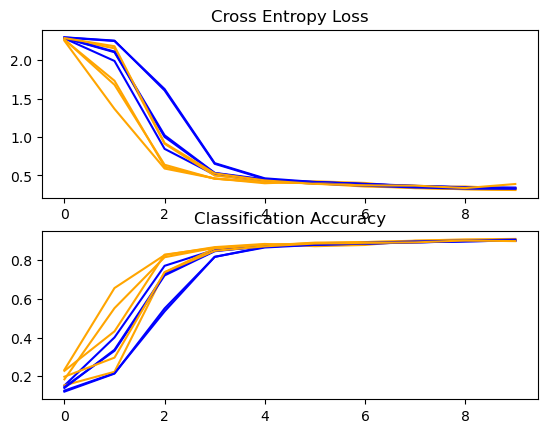

Now PSO estimations
Best Global Loss/Fitness = 0.49041515588760376, Best Accuracy = 0.8459333181381226
Best Local Loss/Fitness = 0.49041515588760376, Best Accuracy = 0.8459333181381226
---------------------------------------------------------
Trial 1: Best Loss/Fitness PSO = 0.49041515588760376, Best Accuracy = 0.8459333181381226
Trial 2: Best Loss/Fitness PSO = 0.49041515588760376, Best Accuracy = 0.8459333181381226
Trial 3: Best Loss/Fitness PSO = 0.49041515588760376, Best Accuracy = 0.8459333181381226
Trial 4: Best Loss/Fitness PSO = 0.49041515588760376, Best Accuracy = 0.8459333181381226

Early stopping at trial 5 - No improvement for 5 consecutive trials.


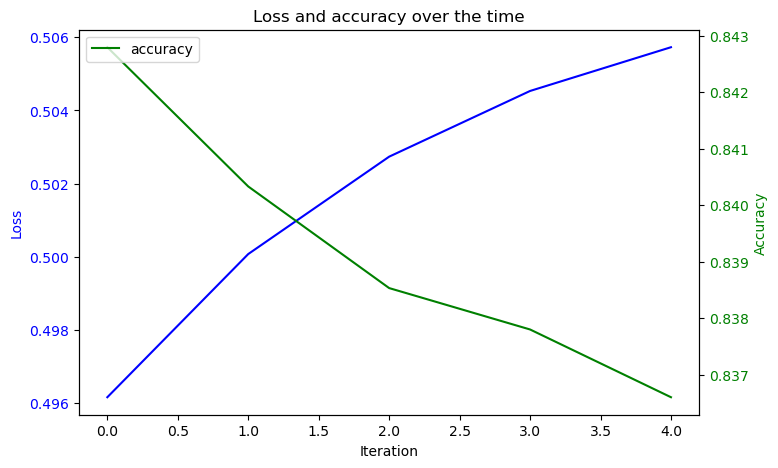

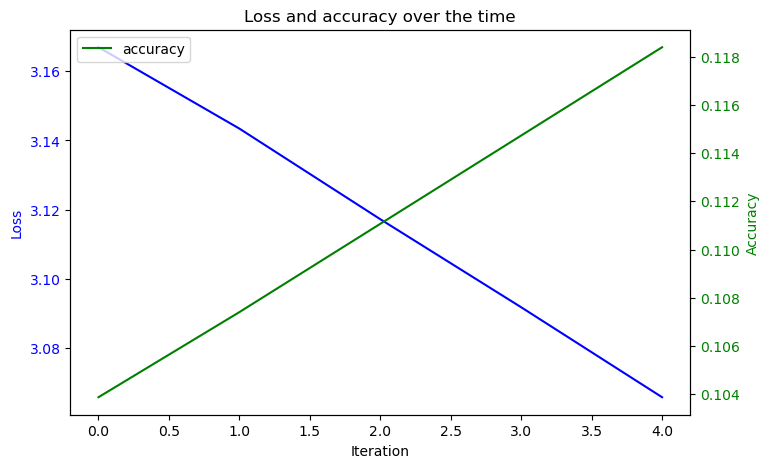

In [53]:
# entry point, run the test harness
setup_run()